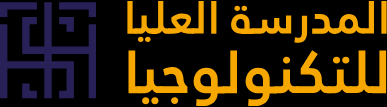
### Higher School of Technology

# 📊 Fraud Detection in Transaction Data
**Prerequisites**

[Machine Learning on Financial Data](Day3.ipynb)

## 🧮 Step 1 – Load and Preprocess the Transaction Dataset
### 🏦 About Dataset

The financial_dataset.csv.csv dataset inludes mobile money transactions from a financial system, aiming to detect fraudulent behavior. It includes detailed logs of individual transactions, capturing financial flows and user interactions over time.

The dataset contains a mix of numerical and categorical variables. The classification task focuses on identifying fraudulent transactions using various transaction attributes. The target variable is located in the isFraud column.

Key features include:
- step – Time step (in hours) from the beginning of the simulation,
- type – Type of transaction (PAYMENT, TRANSFER, CASH_OUT, DEBIT, CASH_IN),
- amount – Amount of the transaction,
- oldbalanceOrg – Initial balance of the originator before the transaction,
- newbalanceOrig – Balance of the originator after the transaction,
- oldbalanceDest – Initial balance of the recipient before the transaction,
- newbalanceDest – Balance of the recipient after the transaction,
-isFraud – 🔑 Target variable (1 if the transaction is fraudulent, 0 otherwise),

isFlaggedFraud – Indicates whether the transaction was flagged as suspicious by internal controls (based on experts classification).

This dataset provides a real-world challenge for machine learning classification models, as fraud instances are rare, making this an imbalanced classification problem.

🧮 Preprocessing Data

To prepare the dataset for machine learning, the following preprocessing steps are applied:

- Encode categorical data into numeric form: The 'type' column is converted from categorical strings (e.g., 'TRANSFER', 'CASH_OUT') into numeric codes using label encoding, allowing models to interpret these values mathematically.
- Drop non-relevant columns: Columns such as nameOrig and nameDest (user identifiers) are removed as they do not contribute meaningfully to fraud prediction and can introduce noise or privacy concerns.
- Separate features from the target variable: The dataset is divided into input features (X) and the output label (y), where y is isFraud.
- Normalize features: Continuous numeric variables (like amount, balances, etc.) are scaled to a 0–1 range using Min-Max normalization, ensuring all features contribute proportionately during training.
- Split the data into training and testing sets: To evaluate generalization, the dataset is split into training (80%) and testing (20%) sets. The split is stratified on the fraud label to maintain class distribution.

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import *

# load dataset
df = pd.read_csv("datasets/financial_dataset.csv")
# view the dataset structure by preview the first 5 rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
1,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
2,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# Statistiques globales
print("Transactions frauduleuses :", df['isFraud'].sum())
print("Transactions signalées :", df['isFlaggedFraud'].sum())

# Distribution des types
print(df['type'].value_counts())

# Types impliqués dans les fraudes
print(df[df['isFraud'] == 1]['type'].value_counts())

# Proportion fraude par type
sns.countplot(data=df, x='type', hue='isFraud')
plt.title('Type vs Fraude')
plt.show()

# Compute correlation between all numerical variables
corr = df.corr(numeric_only=True)
sns.heatmap(round(corr,2),annot=True,cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# encode all categorical data into numeric using map
df['type'] = df['type'].map({'TRANSFER': 0,'PAYMENT': 1,'CASH_OUT': 2,'DEBIT': 3})

# drop non-relevant columns like Loan_id witch is juste an incremental number
df = df.drop(columns=['step'])
df = df.drop(columns=['nameOrig'])
df = df.drop(columns=['nameDest'])

# Define train/test ratio
train_ratio = 0.8
train_size = int(len(df) * train_ratio)

# Split the data into train and test
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# separate the decision making variables from the final decision in the last column
x_train = train.iloc[:,:6]
y_train = train.iloc[:,6]
x_test = test.iloc[:,:6]
y_test = test.iloc[:,6]

# Normalize features
scaler = preprocessing.StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# shapes check
print("x_train shape:", x_train_scaled.shape)
print("x_test shape:", x_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# decision tree classifier
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(x_train_scaled, y_train)
y_pred_tree = tree_model.predict(x_test_scaled)

# compute accuracy
correct = np.sum(y_test == y_pred_tree)
total = len(y_test)
accuracy = correct / total
print("Tree Accuracy: ", round(accuracy,2))

# compute and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Plot the decision tree structure
tree.plot_tree(tree_model, feature_names=x_train.columns, class_names=['Rejected', 'Approved'], filled=True)
plt.title("Decision Tree Structure")
plt.show()

🧮 Step 2 – Unsupervised Fraud Detection via Clustering
🔍 Motivation

Without the isFraud label, the goal is to group transactions into clusters based on their behavior, and then identify outliers or unusual clusters that may correspond to fraud. This is often done using KMeans or DBSCAN clustering algorithms.
⚙️ Key Steps:

- Drop the isFraud and isFlaggedFraud columns to simulate a real-world unlabeled scenario.
- Apply feature engineering to convert categorical features like type into numeric values.
- Scale numerical features using MinMaxScaler or StandardScaler.
- Apply KMeans clustering to group similar transactions.
- Visualize the clusters (if possible) and analyze if small, distinct clusters correspond to suspicious behaviors.

🧠 Assumption

Fraudulent transactions are rare, so they may appear as isolated small clusters or outliers in the feature space.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("datasets/financial_dataset.csv")
df.head()

In [ ]:
# Drop the target and flag columns
df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1, inplace=True)

# Encode the 'type' column
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # e.g., 'TRANSFER' → 4, 'CASH_OUT' → 1, etc.

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

Step 2 – Apply KMeans

In [ ]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

In [ ]:
Step 3 – Apply DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(scaled_data)

In [ ]:
Step 4 – Compare Cluster Distributions

In [ ]:
print("KMeans Cluster Counts:\n", df['kmeans_cluster'].value_counts(), "\n")
print("DBSCAN Cluster Counts:\n", df['dbscan_cluster'].value_counts())

Step 5 – Visualize (PCA)

In [ ]:
# Dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Plot KMeans
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                hue=df['kmeans_cluster'], palette='tab10', s=10)
plt.title('KMeans Clustering')
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")

# Plot DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                hue=df['dbscan_cluster'], palette='tab10', s=10)
plt.title('DBSCAN Clustering')
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

In [ ]:
# Analyze cluster distribution
print(df['cluster'].value_counts())


# Optional: Plot for 2D interpretation using PCA (visual only)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['cluster'], palette='Set2', alpha=0.6)
plt.title('Clustering of Transactions (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

📊 Interpretation

    Small clusters or outliers in PCA scatter plots or with few members in value_counts() may indicate potentially fraudulent behavior.

    These can be further analyzed or reviewed by security analysts for confirmation.

In [ ]:
🧮 Step 3 – Fraud Detection with DBSCAN (Density-Based Clustering)
🧠 Why DBSCAN?

Unlike KMeans, which requires predefining the number of clusters, DBSCAN automatically identifies clusters based on density and marks low-density points as outliers — which is ideal for spotting potentially fraudulent transactions.
✅ Key Concepts:

    eps: Maximum distance between two samples for them to be considered neighbors.

    min_samples: Minimum number of samples in a neighborhood to form a dense region.

    Noise points (labeled -1) are potential fraud candidates.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

# Drop label and identifiers to simulate unlabeled anomaly detection
df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1, inplace=True)

# Encode 'type' column to numeric
df['type'] = LabelEncoder().fit_transform(df['type'])

# Normalize features
scaled_data = MinMaxScaler().fit_transform(df)

# Apply DBSCAN
db = DBSCAN(eps=0.05, min_samples=5)  # You can tune eps based on the dataset size
df['cluster'] = db.fit_predict(scaled_data)

# Count points in each cluster
print("Cluster distribution:")
print(df['cluster'].value_counts())

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['cluster'], palette='tab10', alpha=0.6)
plt.title("DBSCAN Fraud Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()